In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import requests
import re
import tarfile
import io
from io import BytesIO
import os
from astropy.io import fits
from astropy.table import QTable
from astropy.table import Table
import healpy as hp
import astropy_healpix as ah
import astropy.units as u
import ligo.skymap.plot
import ligo.skymap.postprocess
import ligo.skymap.io

from ligo.gracedb.rest import GraceDb

g = GraceDb()

In [2]:
# to dos

# check for more events on gwosc

# save skymaps for not just high mass mergers

# get initial and final skymaps for O3 events with mass > 80 msol

get the final versions of skymaps published on gwosc

- bug: not finding some skymaps matching inference used in LITD (specifically NRSur7dq4)

In [4]:
# get skymaps published in GWOSC catalog
df_gwosc = pd.read_csv("../data/ligo-O3-gwosc.csv")

# specify which skymap inference to use based on light in the dark
df_gwosc["litd_inference"] = df_gwosc["reference"].apply(
    lambda x: "IMRPhenomXPHM.fits"
    if x == "/GWTC-3/"
    else "NRSur7dq4.fits"
    if x == "/GWTC-2.1/"
    else None
)
# LITD * use SEOBNRv4PHM
litd_seo = [
    "GW190408_181802",
    "GW190412",
    "GW190426_152155",
    "GW190512_180714",
    "GW190707_093326",
    "GW190708_232457",
    "GW190720_000836",
    "GW190728_064510",
    "GW190814",
    "GW190828_065509",
    "GW190909_114149",
    "GW190915_235702",
    "GW190924_021846",
    "GW190929_012149",
    "GW190930_133541",
]
df_gwosc["litd_inference"] = df_gwosc.apply(
    lambda row: "SEOBNRv4PHM.fits"
    if any(substring in row["id"] for substring in litd_seo)
    else row["litd_inference"],
    axis=1,
)

# get high mass subset and extract names
highmass_only = False
if highmass_only:
    df_gwosc = df_gwosc[df_gwosc["total_mass_source"] > 80].reset_index(drop=True)
event_names = df_gwosc["commonName"]

In [5]:
# the final published skymap


def get_gwosc_skymap_urls(xml):
    response = requests.get(xml).text
    pattern = re.compile(
        r'"skymap":\s*"(https://[^"]+content)"|\'skymap\':\s*\'(https://[^\']+content)\''
    )
    match = pattern.search(response)
    if match:
        skymap_url = match.group(1)
        return skymap_url
    else:
        return None


# all skymaps are in one of three zenodo links
gwosc_highmass_skymap_urls = list(
    set([get_gwosc_skymap_urls(file) for file in df_gwosc["jsonurl"]])
)
print(f"all skymaps are in one of three zenodo links: {gwosc_highmass_skymap_urls}")

all skymaps are in one of three zenodo links: ['https://zenodo.org/api/records/6513631/files/IGWN-GWTC2p1-v2-PESkyMaps.tar.gz/content', 'https://zenodo.org/api/records/5546663/files/skymaps.tar.gz/content', 'https://zenodo.org/api/records/5117703/files/IGWN-GWTC2p1-v1-PESkyMaps.tar.gz/content']


In [6]:
# test inference selection done in function below
i = 13
litd_inference = df_gwosc["litd_inference"][i]
url = get_gwosc_skymap_urls(df_gwosc["jsonurl"][i])
response = requests.get(url)
tar = tarfile.open(fileobj=io.BytesIO(response.content), mode="r:gz")
event = event_names[i]
skymap_fits = [member.name for member in tar.getmembers() if event in member.name]
pref_inference = (
    [x for x in skymap_fits if litd_inference in x]
    + [x for x in skymap_fits if "IMRPhenomXPHM.fits" in x]
    + [x for x in skymap_fits if "NRSur7dq4.fits" in x]
    + [None]
)
select_inference = pref_inference[0]
print(f"pref_inference: {pref_inference}")
print(f"select_inference: {select_inference}")

pref_inference: ['IGWN-GWTC2p1-v2-GW190519_153544_PEDataRelease_cosmo_reweight_C01:IMRPhenomXPHM.fits', None]
select_inference: IGWN-GWTC2p1-v2-GW190519_153544_PEDataRelease_cosmo_reweight_C01:IMRPhenomXPHM.fits


In [7]:
def get_skymaps_gwosc(jsonurl, inf, event):
    url = get_gwosc_skymap_urls(jsonurl)
    response = requests.get(url)
    tar = tarfile.open(fileobj=io.BytesIO(response.content), mode="r:gz")
    skymap_fits = [member.name for member in tar.getmembers() if event in member.name]
    pref_inference = (
        [x for x in skymap_fits if inf in x]
        + [x for x in skymap_fits if "IMRPhenomXPHM.fits" in x]
        + [x for x in skymap_fits if "NRSur7dq4.fits" in x]
        + [None]
    )
    select_inference = pref_inference[0]
    if select_inference:
        try:
            fileobj = tar.extractfile(select_inference)
            hdul = fits.open(fileobj)
            skymap = QTable.read(hdul)
            return event, skymap, select_inference
        except Exception as e:
            skymap = None
            print(f"Failed to read {skymap_fits[0]}: {e}")
            return event, skymap, select_inference


json_url = df_gwosc["jsonurl"]
litd_inference = df_gwosc["litd_inference"]
event_names = df_gwosc["commonName"]
gwosc_skymaps = [
    get_skymaps_gwosc(url, inf, event)
    for url, inf, event in zip(json_url, litd_inference, event_names)
]

In [23]:
eventids = [x[0] if x is not None and x[0] is not None else None for x in gwosc_skymaps]
skymaps_gwosc = [
    x[1] if x is not None and x[1] is not None else None for x in gwosc_skymaps
]
inference = [
    x[2] if x is not None and x[2] is not None else None for x in gwosc_skymaps
]

if len(event_names) != len(eventids):
    print("did not retrieve all events - manually inspect")

now get original versions of skymaps from gracedb

In [3]:
event_iterator = g.superevents("O3")
graceids_O3 = [superevent["superevent_id"] for superevent in event_iterator]
print(f"{len(graceids_O3)} O3 events")

In [25]:
# get ids for gracedb
# should use eventids, but have a bug with those and event_names is equivalent if we return all events
responses = [requests.get(j) for j in json_url]
events = [next(iter(response.json()["events"].values())) for response in responses]
graceids = [event["gracedb_id"] for event in events]

In [26]:
# not all ids i have from gwosc are in gracedb ...
common_graceids = set(graceids).intersection(graceids_O3)
print(f"{len(common_graceids)}")

{'S200208q', 'S190521g', 'S190701ah', 'S190602aq', 'S190513bm', 'S200129m', 'S190706ai', 'S190412m', 'S200115j', 'S200219ac', 'S190503bf', 'S190425z', 'S190828l', 'S191105e', 'S190814bv', 'S191109d', 'S190727h', 'S191222n', 'S191129u', 'S190828j', 'S200224ca', 'S191215w', 'S190915ak', 'S190519bj', 'S191216ap', 'S190408an', 'S200311bg', 'S190512at', 'S190421ar', 'S190930s', 'S190517h', 'S200128d', 'S190521r', 'S190924h', 'S200316bj', 'S190728q', 'S200302c', 'S200112r', 'S200225q', 'S191204r', 'S190707q', 'S190630ag', 'S190720a'}


In [74]:
# testing function below
example = "S200208q"
event_files = g.files(example).json()
mocs = [k for k in list(event_files) if "multiorder" in k]
if not mocs:
    url = "none"
    print(example)

else:
    if any("LALInference" in item for item in mocs):
        mocs = [k for k in mocs if "LALInference" in k]
    key = [
        mocs
        if len(mocs) == 1
        else list(filter(lambda k: "2" in k, mocs))[0]
        if list(filter(lambda k: "2" in k, mocs))
        else list(filter(lambda k: "1" in k, mocs))[0]
        if list(filter(lambda k: "1" in k, mocs))
        else "LALInference.multiorder.fits"
        if "LALInference.multiorder.fits" in mocs
        else list(filter(lambda k: "0" in k, mocs))[0]
        if list(filter(lambda k: "0" in k, mocs))
        else mocs[0]
    ]

    url = event_files[key[0]]

print(f"{example}: {url}")

S200208q: https://gracedb.ligo.org/api/superevents/S200208q/files/LALInference.multiorder.fits


In [76]:
def get_moc_urls(graceid):
    try:
        event_files = g.files(graceid).json()
        mocs = [k for k in list(event_files) if "multiorder" in k]
        if not mocs:
            url = "none"
            print(graceid)

        else:
            if any("LALInference" in item for item in mocs):
                mocs = [k for k in mocs if "LALInference" in k]
            key = [
                mocs
                if len(mocs) == 1
                else list(filter(lambda k: "2" in k, mocs))[0]
                if list(filter(lambda k: "2" in k, mocs))
                else list(filter(lambda k: "1" in k, mocs))[0]
                if list(filter(lambda k: "1" in k, mocs))
                else "bayestar.multiorder.fits"
                if "bayestar.multiorder.fits" in mocs
                else list(filter(lambda k: "0" in k, mocs))[0]
                if list(filter(lambda k: "0" in k, mocs))
                else mocs[0]
            ]

            url = event_files[key[0]]
            print(f"{graceid}: {url}")
    except Exception:
        url = None
    return url

In [77]:
skymap_urls_gracedb = [get_moc_urls(graceid) for graceid in graceids]
none_count = sum(1 for item in skymap_urls_gracedb if item is None)
print(f"Failed to get skymap for {none_count} IDs")

S190408an: https://gracedb.ligo.org/api/superevents/S190408an/files/GW190408_181802_PublicationSamples.multiorder.fits
S190412m: https://gracedb.ligo.org/api/superevents/S190412m/files/GW190412_PublicationSamples.multiorder.fits
S190421ar: https://gracedb.ligo.org/api/superevents/S190421ar/files/GW190421_213856_PublicationSamples.multiorder.fits
S190425z: https://gracedb.ligo.org/api/superevents/S190425z/files/GW190425_PublicationSamples.multiorder.fits
S190503bf: https://gracedb.ligo.org/api/superevents/S190503bf/files/GW190503_185404_PublicationSamples.multiorder.fits
S190512at: https://gracedb.ligo.org/api/superevents/S190512at/files/GW190512_180714_PublicationSamples.multiorder.fits
S190513bm: https://gracedb.ligo.org/api/superevents/S190513bm/files/GW190513_205428_PublicationSamples.multiorder.fits
S190517h: https://gracedb.ligo.org/api/superevents/S190517h/files/GW190517_055101_PublicationSamples.multiorder.fits
S190519bj: https://gracedb.ligo.org/api/superevents/S190519bj/files/

In [81]:
valid_indexes = [i for i, value in enumerate(skymap_urls_gracedb) if value is not None]
gracedb_urls = [skymap_urls_gracedb[i] for i in valid_indexes]
gwosc_files = [skymaps_gwosc[i] for i in valid_indexes]
names = [graceids[i] for i in valid_indexes]
print(f"found {len(names)} skymaps in gracedb")

found 43 skymaps in gracedb


In [79]:
# download skymap files


def download_gracedb_files(urls, names):
    for url, name in zip(urls, names):
        try:
            file_path = f"../data/skymaps/gracedbO3/{name}.fits"
            response = requests.get(url)
            with open(file_path, "wb") as f:
                f.write(response.content)
        except Exception as e:
            print(f"An error occurred: {e}")


def download_gwosc_files(files, names):
    for file, name in zip(files, names):
        try:
            file_path = f"../data/skymaps/gwoscO3/{name}.fits"
            if isinstance(file, QTable):
                file.write(file_path, format="fits", overwrite=True)
            else:
                print(f"The file {name} is not a QTable object.")
        except Exception as e:
            print(f"An error occurred: {e}")

In [82]:
download_gracedb_files(gracedb_urls, names)

In [33]:
download_gwosc_files(skymaps_gwosc, names)

The file S190513bm is not a QTable object.


# what is the change from initial to final skymaps

https://github.com/ricokaloklo/skymap-overlap/tree/master

In [83]:
def load_skymaps(path):
    skymaps = []
    names = []
    for file in os.listdir(path):
        if file.endswith(".fits"):
            hpx, _ = ligo.skymap.io.fits.read_sky_map(f"{path}/{file}")
            skymaps.append(hpx)
            name = file.split(".")[0]
            names.append(name)
    print(f"Loaded {len(skymaps)} skymaps: {names}")
    return skymaps, names


gracedb_skymaps, gracedbids = load_skymaps("../data/skymaps/gracedbO3/")
gwosc_skymaps, gwoscids = load_skymaps("../data/skymaps/gwoscO3/")

Loaded 43 skymaps: ['S190513bm', 'S190915ak', 'S190706ai', 'S200219ac', 'S190924h', 'S190512at', 'S200225q', 'S190828j', 'S190412m', 'S190425z', 'S191216ap', 'S190408an', 'S200112r', 'S200302c', 'S191109d', 'S200128d', 'S200129m', 'S191204r', 'S191222n', 'S190521r', 'S200208q', 'S200316bj', 'S190720a', 'S200224ca', 'S200115j', 'S190519bj', 'S190421ar', 'S200311bg', 'S190701ah', 'S190814bv', 'S190517h', 'S190828l', 'S190707q', 'S190727h', 'S190630ag', 'S191215w', 'S191129u', 'S190521g', 'S190602aq', 'S190930s', 'S190728q', 'S191105e', 'S190503bf']
Loaded 42 skymaps: ['S190915ak', 'S190706ai', 'S200219ac', 'S190924h', 'S190512at', 'S200225q', 'S190828j', 'S190412m', 'S190425z', 'S191216ap', 'S190408an', 'S200112r', 'S200302c', 'S191109d', 'S200128d', 'S200129m', 'S191204r', 'S191222n', 'S190521r', 'S200208q', 'S200316bj', 'S190720a', 'S200224ca', 'S200115j', 'S190519bj', 'S190421ar', 'S200311bg', 'S190701ah', 'S190814bv', 'S190517h', 'S190828l', 'S190707q', 'S190727h', 'S190630ag', 'S191

In [85]:
# only keep skymaps that are in both sets
#'S190513bm' has a gracedb skymap but not a gwosc one

common_ids = set(gracedbids).intersection(gwoscids)
gracedb_indexes = [i for i, value in enumerate(gracedbids) if value in common_ids]
gwosc_indexes = [i for i, value in enumerate(gwoscids) if value in common_ids]
gracedb_skymaps = [gracedb_skymaps[i] for i in gracedb_indexes]
gwosc_skymaps = [gwosc_skymaps[i] for i in gwosc_indexes]
common_ids = [common_ids for i in range(len(gracedb_skymaps))]
print(f"found {len(common_ids)} skymaps in both sets")

found 42 skymaps in both sets


In [86]:
# prep skymaps


def enforce_same_resolution(*skymaps):
    """
    Enforce that all skymaps have the same resolution

    Parameters
    ----------
    skymaps : list of skymaps

    Returns
    -------
    skymaps : list of skymaps
    """
    skymaps = list(skymaps)
    nside_min = np.amin([hp.get_nside(hpx) for hpx in skymaps])
    for i in range(len(skymaps)):
        skymaps[i] = ligo.skymap.postprocess.util.smooth_ud_grade(skymaps[i], nside_min)
    return skymaps

In [87]:
# 1. posterior overlap


def compute_posterior_overlap(*skymaps):
    _out = np.zeros_like(skymaps[0])
    for skymap in skymaps:
        _out += np.log(skymap)
    overlap = np.nansum(np.exp(_out))
    return overlap


def compute_normalized_posterior_overlap(*skymaps):
    unormalized = compute_posterior_overlap(*skymaps)
    normalization = np.prod([np.sqrt(compute_posterior_overlap(m, m)) for m in skymaps])
    overlap = unormalized / normalization
    return overlap


# 2. 90% credible region overlap


def compute_credible_region_overlap(*skymaps, percent=90):
    masked_skymaps = [np.zeros_like(skymap) for skymap in skymaps]
    for skymap in skymaps:
        masked_skymap = np.zeros_like(skymap)
        masked_skymap[
            ligo.skymap.postprocess.util.find_greedy_credible_levels(masked_skymap)
            <= percent / 100.0
        ] = 1.0
        num_masked_pixels = len(masked_skymap[masked_skymap == 1.0])
    joint_masked_skymaps = np.multiply(*masked_skymaps)
    num_masked_pixels = len(joint_masked_skymaps[joint_masked_skymaps == 1.0])
    overlap = num_masked_pixels / np.amin([len(m[m == 1.0]) for m in masked_skymaps])
    return overlap

In [38]:
def skymap_overlap(*skymaps):
    skymaps = enforce_same_resolution(*skymaps)
    posterior_overlap = compute_posterior_overlap(*skymaps)
    normalized_posterior_overlap = compute_normalized_posterior_overlap(*skymaps)
    overlap_90 = compute_credible_region_overlap(*skymaps, percent=90)
    print(
        f"Posterior overlap: {posterior_overlap}, Normalized posterior overlap: {normalized_posterior_overlap}, 90% credible region overlap: {overlap_90}"
    )
    return posterior_overlap, normalized_posterior_overlap, overlap_90


overlap = [
    skymap_overlap(gracedb_skymaps[i], gwosc_skymaps[i])
    for i in range(len(gracedb_skymaps))
]

/tmp/ipykernel_3549/658873499.py:6: RuntimeWarning: divide by zero encountered in log
  _out += np.log(skymap)
/tmp/ipykernel_3549/658873499.py:6: RuntimeWarning: invalid value encountered in log
  _out += np.log(skymap)
/tmp/ipykernel_3549/658873499.py:26: RuntimeWarning: invalid value encountered in scalar divide
  overlap = num_masked_pixels / np.amin([len(m[m == 1.0]) for m in masked_skymaps])


Posterior overlap: 1.3459908503387996e-11, Normalized posterior overlap: 3.9918555905155773e-07, 90% credible region overlap: nan
Posterior overlap: 3.3616380960972387e-07, Normalized posterior overlap: 0.011115731006566956, 90% credible region overlap: nan
Posterior overlap: 4.2845501501110395e-07, Normalized posterior overlap: 0.012926543002802328, 90% credible region overlap: nan
Posterior overlap: 1.1105790641884616e-05, Normalized posterior overlap: 0.07563310270059655, 90% credible region overlap: nan
Posterior overlap: 3.572200117833709e-61, Normalized posterior overlap: 2.5108490033199056e-57, 90% credible region overlap: nan
Posterior overlap: 1.3667544776219943e-16, Normalized posterior overlap: 5.673126513871511e-13, 90% credible region overlap: nan
Posterior overlap: 0.0, Normalized posterior overlap: 0.0, 90% credible region overlap: nan
Posterior overlap: 1.0082105907597415e-10, Normalized posterior overlap: 1.0201242570960057e-06, 90% credible region overlap: nan
Posteri

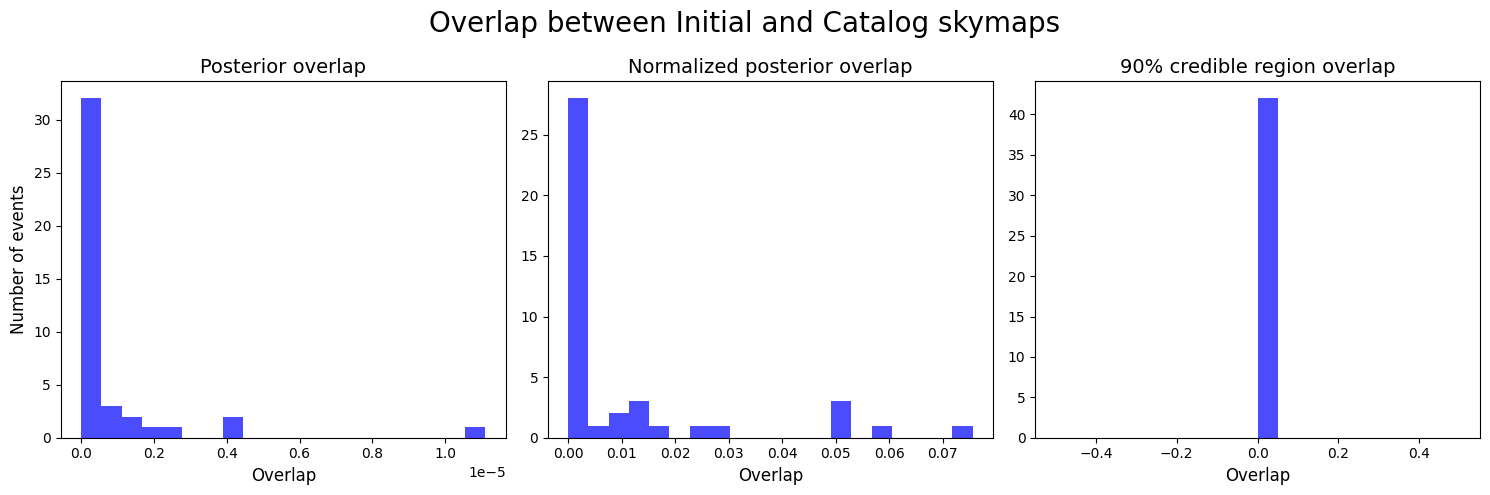

In [88]:
posterior_overlap = [x[0] for x in overlap]
normalized_posterior_overlap = [x[1] for x in overlap]
overlap_90 = [0 if np.isnan(x[2]) else x[2] for x in overlap]

# make three side by side historgrams
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].hist(posterior_overlap, bins=20, color="blue", alpha=0.7)
ax[0].set_title("Posterior overlap", fontsize=14)
ax[0].set_xlabel("Overlap", fontsize=12)
ax[0].set_ylabel("Number of events", fontsize=12)

ax[1].hist(normalized_posterior_overlap, bins=20, color="blue", alpha=0.7)
ax[1].set_title("Normalized posterior overlap", fontsize=14)
ax[1].set_xlabel("Overlap", fontsize=12)

ax[2].hist(overlap_90, bins=20, color="blue", alpha=0.7)
ax[2].set_title("90% credible region overlap", fontsize=14)
ax[2].set_xlabel("Overlap", fontsize=12)

fig.suptitle("Overlap between Initial and Catalog skymaps", fontsize=20)

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import ligo.skymap.postprocess


def plot_skymaps_v2(skymaps, event, labels, colors, RA_unit="hours"):
    fig = plt.figure(figsize=(10, 5))
    if RA_unit == "degrees":
        ax = fig.add_subplot(111, projection="astro degrees mollweide")
    elif RA_unit == "hours":
        ax = fig.add_subplot(111, projection="astro hours mollweide")
    else:
        raise ValueError(f"Does not understand {RA_unit}")
    ax.grid()
    contours = [
        ax.contour_hpx(
            (ligo.skymap.postprocess.util.find_greedy_credible_levels(skymap), "ICRS"),
            levels=[0.5, 0.9],
            linewidths=1,
            nested=False,
            colors=colors[idx],
        )
        for idx, skymap in enumerate(skymaps)
    ]
    patches = [
        mpatches.Patch(color=colors[idx], label=label)
        for idx, label in enumerate(labels)
    ]
    for idx, contour in enumerate(contours):
        ax.clabel(contour, inline=True, fontsize=6)
    plt.legend(handles=patches, loc=0)
    plt.title(event)
    plt.show()


# plot_skymaps_v2(
#     [skymap1, skymap2],
#     eventname_for_title="Example",
#     labels=["Initial GCN", "Final Catalogue"],
#     colors=["blue", "orange"],
# )

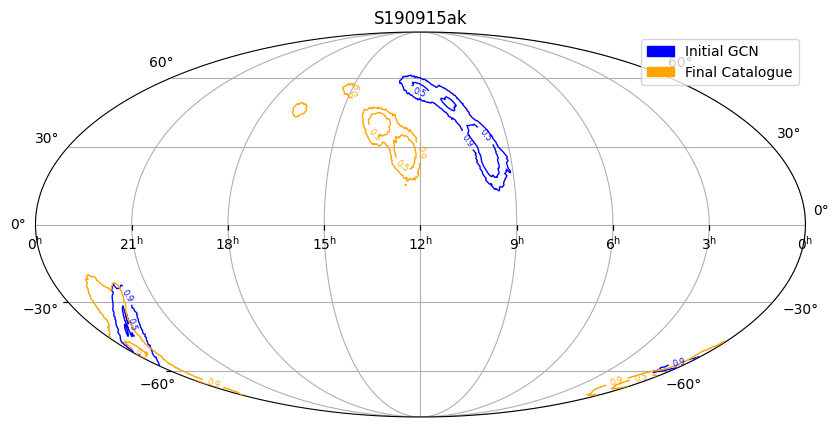

In [166]:
# plot initial and final skymaps


def plot_skymaps(skymaps, event, labels, colors, RA_unit="hours"):
    """
    Plot skymaps

    Parameters
    ----------
    skymaps : list of skymaps
    labels : list of labels
    colors : list of colors
    RA_unit : unit for the right ascension, either hours or degrees
    """
    # Sanity check
    assert len(skymaps) == len(labels)
    assert len(skymaps) == len(colors)

    skymaps = enforce_same_resolution(*skymaps)

    fig = plt.figure(figsize=(10, 5))

    if RA_unit == "degrees":
        ax = fig.add_subplot(111, projection="astro degrees mollweide")
    elif RA_unit == "hours":
        ax = fig.add_subplot(111, projection="astro hours mollweide")
    else:
        raise ValueError(f"Does not understand {RA_unit}")

    ax.grid()

    contours = [
        ax.contour_hpx(
            (ligo.skymap.postprocess.util.find_greedy_credible_levels(skymap), "ICRS"),
            levels=[0.5, 0.9],
            linewidths=1,
            nested=False,
            colors=colors[idx],
        )
        for idx, skymap in enumerate(skymaps)
    ]

    patches = [
        mpatches.Patch(color=colors[idx], label=label)
        for idx, label in enumerate(labels)
    ]

    for idx, contour in enumerate(contours):
        ax.clabel(contour, inline=True, fontsize=6)

    plt.legend(handles=patches, loc=0)
    plt.title(event)
    plt.show()


index = 1
plot_skymaps(
    [gracedb_skymaps[index], gwosc_skymaps[index]],
    event=gracedbids[index],
    labels=["Initial GCN", "Final Catalogue"],
    colors=["blue", "orange"],
)

# additional comparisons

In [151]:
# load skymaps with QTable from fits files in '../data/skymaps/gracedbO3/' and '../data/skymaps/gwoscO3/'


def load_skymaps(directory):
    skymaps = []
    names = []
    for filename in os.listdir(directory):
        if filename.endswith(".fits"):
            filepath = os.path.join(directory, filename)
            with open(filepath, "rb") as f:
                skymap_bytes = f.read()
                skymap = Table.read(BytesIO(skymap_bytes))
                skymaps.append(skymap)
                name = filename.split(".")[0]
                names.append(name)
    return skymaps, names


gracedb_skymaps_forstats, gracedb_stats = load_skymaps("../data/skymaps/gracedbO3/")
gwosc_skymaps_forstats, gwosc_stats = load_skymaps("../data/skymaps/gwoscO3/")

In [152]:
# Only keep skymaps that are in both sets
# 'S190513bm' has a gracedb skymap but not a gwosc one

common_ids = set(gracedb_stats).intersection(gwosc_stats)
gracedb_indexes = [i for i, value in enumerate(gracedb_stats) if value in common_ids]
gwosc_indexes = [i for i, value in enumerate(gwosc_stats) if value in common_ids]

# Ensure the correct list names are used
gracedb_skymaps_forstats = [gracedb_skymaps_forstats[i] for i in gracedb_indexes]
gwosc_skymaps_forstats = [gwosc_skymaps_forstats[i] for i in gwosc_indexes]

common_ids_stats = list(common_ids)
print(f"found {len(common_ids_stats)} skymaps in both sets")

found 42 skymaps in both sets


In [159]:
# get stats from skymap and put in dataframe


def get_a(skymap, probarea):
    """
    Get the area in sq deg of a % credible region
    """
    skymap.sort("PROBDENSITY", reverse=True)
    level, ipix = ah.uniq_to_level_ipix(skymap["UNIQ"])
    pixel_area = ah.nside_to_pixel_area(ah.level_to_nside(level))
    prob = pixel_area * skymap["PROBDENSITY"]
    cumprob = np.cumsum(prob)
    # probarea = probarea.to(u.one).value # bandaid, should understand actual problem
    i = cumprob.searchsorted(probarea)
    area = (pixel_area[:i].sum()).to_value(u.deg**2)
    return area


def get_stats(old_skymap_list, new_skymap_list, names):
    a50_old = [get_a(skymap_old, 0.5) for skymap_old in old_skymap_list]
    a90_old = [get_a(skymap_old, 0.9) for skymap_old in old_skymap_list]
    distmean_old = [skymap_old.meta["DISTMEAN"] for skymap_old in old_skymap_list]
    diststd_old = [skymap_old.meta["DISTSTD"] for skymap_old in old_skymap_list]
    a50_new = [get_a(skymap_new, 0.5) for skymap_new in new_skymap_list]
    a90_new = [get_a(skymap_new, 0.9) for skymap_new in new_skymap_list]
    distmean_new = [skymap_new.meta["DISTMEAN"] for skymap_new in new_skymap_list]
    diststd_new = [skymap_new.meta["DISTSTD"] for skymap_new in new_skymap_list]
    data = {
        "a50_old": a50_old,
        "a50_new": a50_new,
        "a50 delta": np.array(a50_new) - np.array(a50_old),
        "a90_old": a90_old,
        "a90_new": a90_new,
        "a90 delta": np.array(a90_new) - np.array(a90_old),
        "distmean_old": distmean_old,
        "distmean_new": distmean_new,
        "distmean delta": np.array(distmean_new) - np.array(distmean_old),
        "diststd_old": diststd_old,
        "diststd_new": diststd_new,
        "diststd delta": np.array(diststd_new) - np.array(diststd_old),
    }
    # Create the DataFrame
    df = pd.DataFrame(data, index=names)
    return df

In [161]:
df = get_stats(gracedb_skymaps_forstats, gwosc_skymaps_forstats, common_ids_stats)

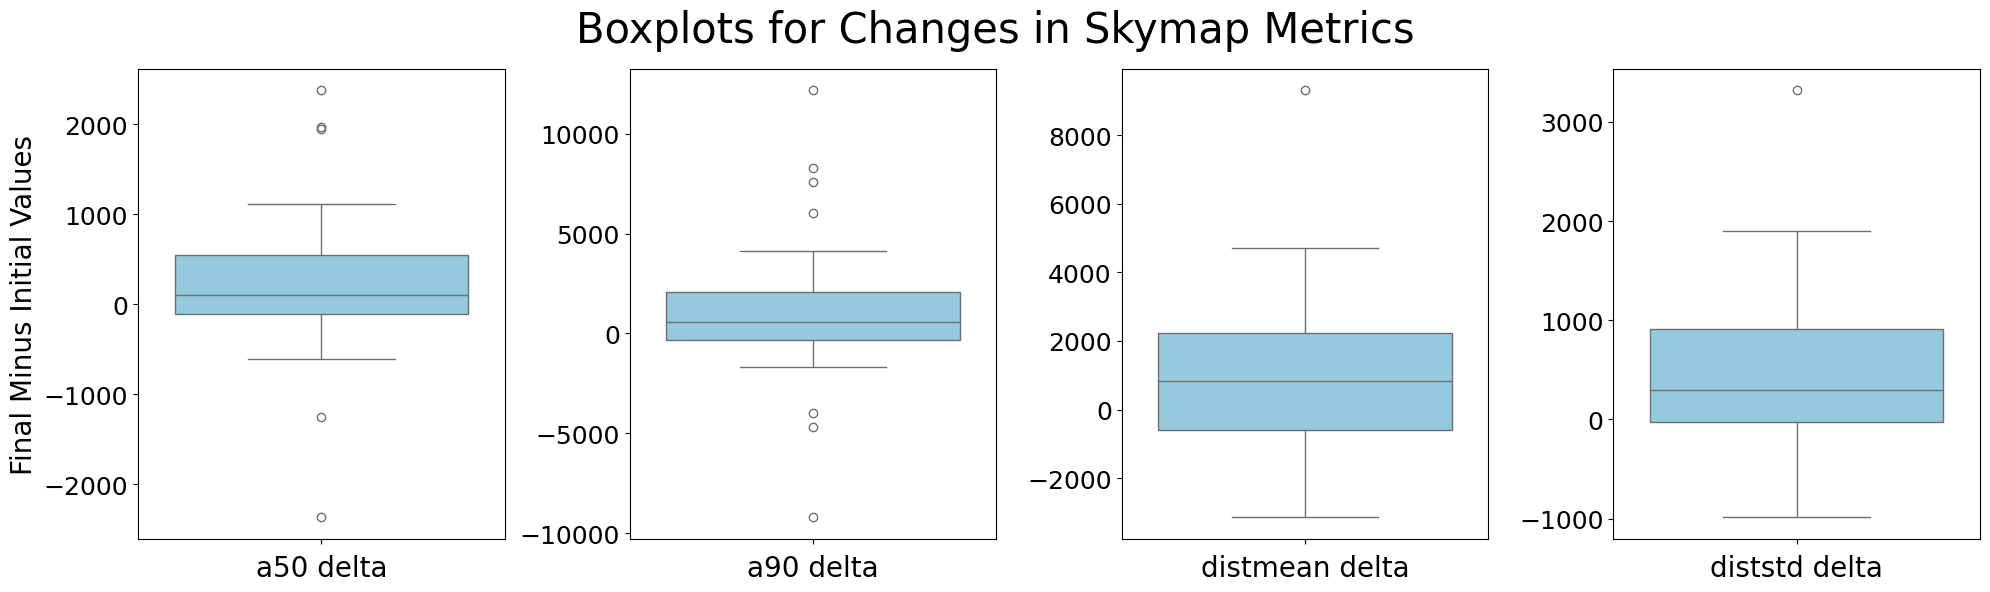

In [163]:
delta_columns = [col for col in df.columns if "delta" in col]
df_delta = df[delta_columns]

num_plots = len(delta_columns)
fig, axes = plt.subplots(nrows=1, ncols=num_plots, figsize=(5 * num_plots, 6))

for i, col in enumerate(delta_columns):
    sns.boxplot(data=df_delta, y=col, ax=axes[i], color="skyblue")
    axes[i].set_xlabel(f"{col}", fontsize=20)
    axes[i].set_ylabel("")  # Remove y-axis label
    axes[i].tick_params(axis="y", labelsize=18)
axes[0].set_ylabel("Final Minus Initial Values", fontsize=20)

plt.suptitle("Boxplots for Changes in Skymap Metrics", fontsize=30)
plt.tight_layout()
plt.show()

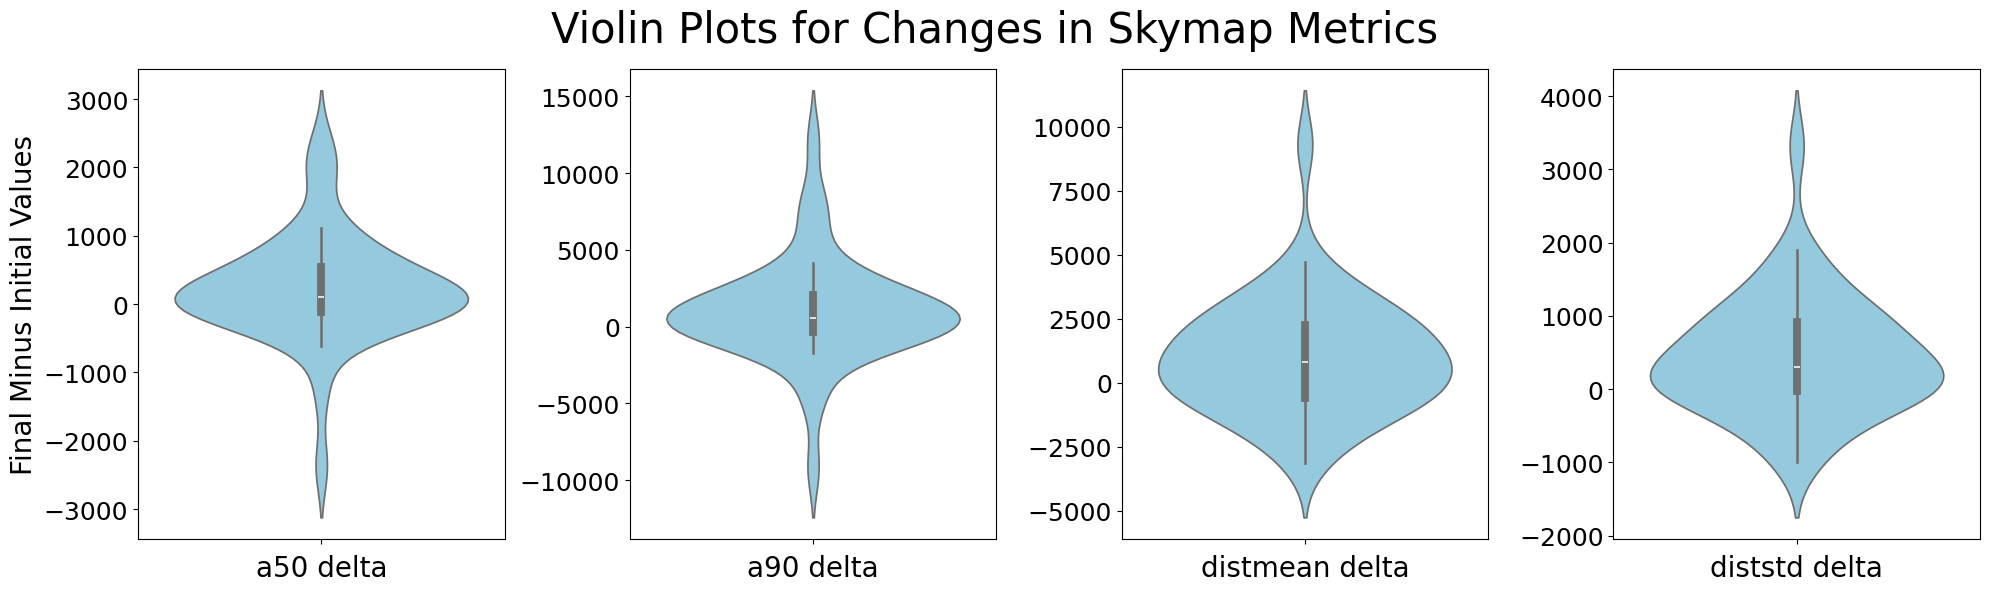

In [164]:
delta_columns = [col for col in df.columns if "delta" in col]
df_delta = df[delta_columns]

num_plots = len(delta_columns)
fig, axes = plt.subplots(nrows=1, ncols=num_plots, figsize=(5 * num_plots, 6))

for i, col in enumerate(delta_columns):
    sns.violinplot(data=df_delta, y=col, ax=axes[i], color="skyblue")
    axes[i].set_xlabel(f"{col}", fontsize=20)
    axes[i].set_ylabel("")  # Remove y-axis label
    axes[i].tick_params(axis="y", labelsize=18)
axes[0].set_ylabel("Final Minus Initial Values", fontsize=20)

plt.suptitle("Violin Plots for Changes in Skymap Metrics", fontsize=30)
plt.tight_layout()
plt.show()

In [ ]:
# trend search - do areas get bigger or smaller. Do skymaps shift in one direction more than others?
# histogram a90 delta


# chirp mass experiments

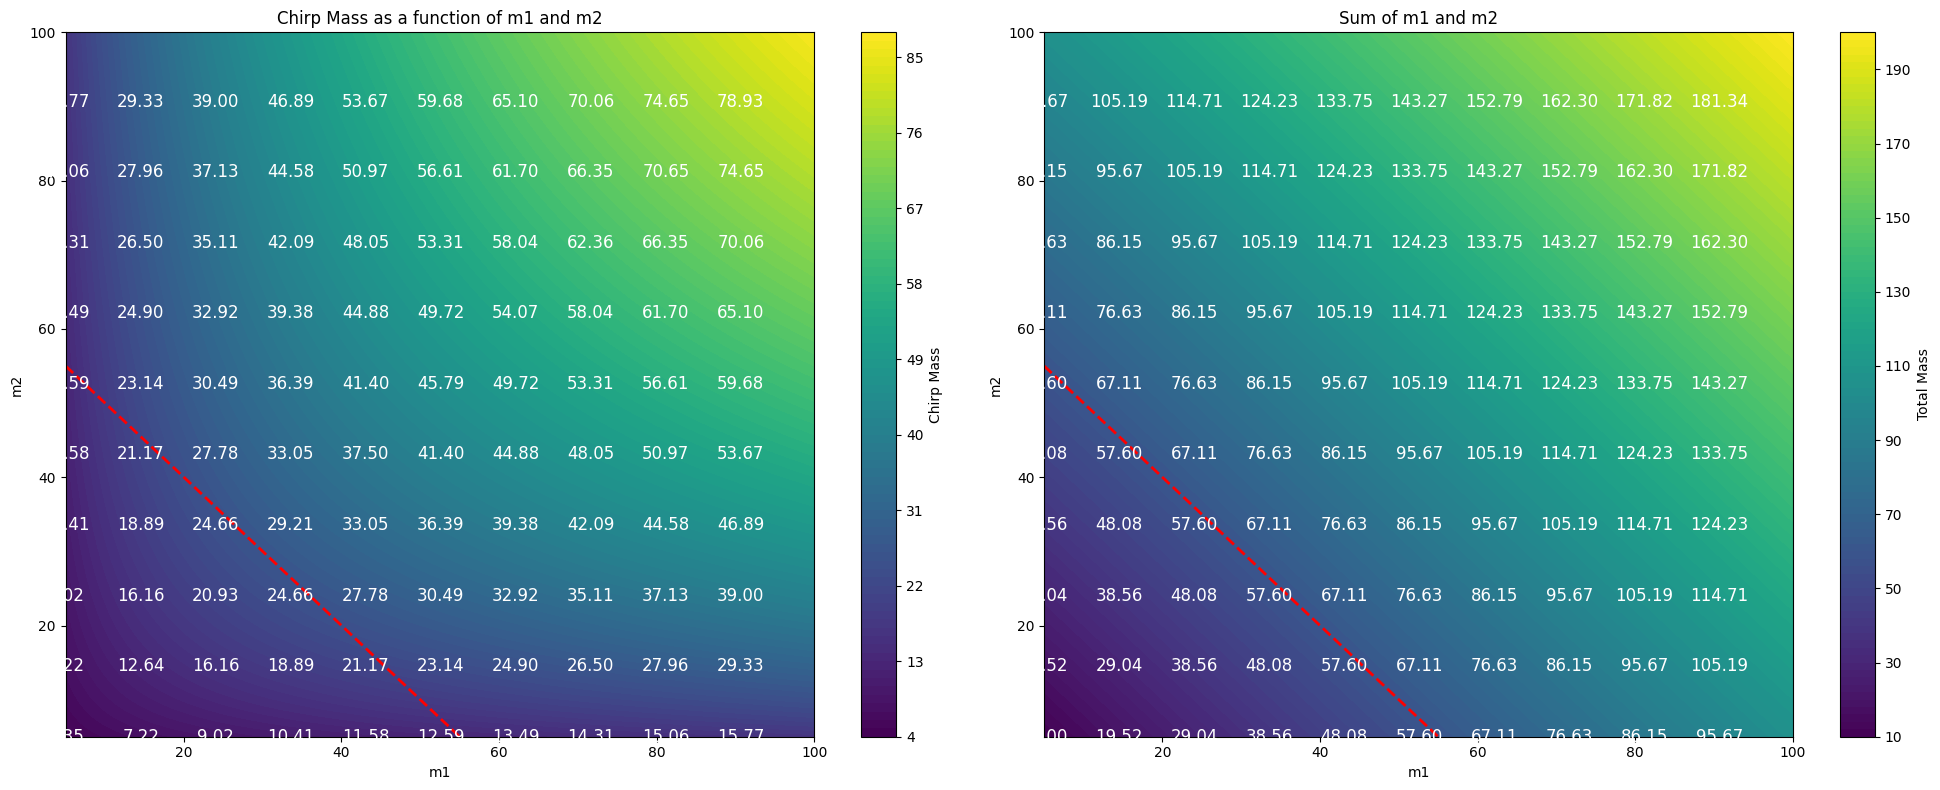

In [170]:
# Define the range for m1 and m2 with finer binning
m1 = np.linspace(5, 100, 500)
m2 = np.linspace(5, 100, 500)

# Create a meshgrid
M1, M2 = np.meshgrid(m1, m2)

# Calculate chirp_mass and m1 + m2
chirp_mass = (M1 * M2) ** (3 / 5) / (M1 + M2) ** (1 / 5)
sum_mass = M1 + M2

# Create the figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot the chirp_mass
contour1 = ax1.contourf(M1, M2, chirp_mass, levels=100, cmap="viridis")
fig.colorbar(contour1, ax=ax1, label="Chirp Mass")
ax1.set_xlabel("m1")
ax1.set_ylabel("m2")
ax1.set_title("Chirp Mass as a function of m1 and m2")

# Add text annotations for chirp_mass
for i in range(0, M1.shape[0], 50):
    for j in range(0, M2.shape[1], 50):
        ax1.text(
            M1[i, j],
            M2[i, j],
            f"{chirp_mass[i, j]:.2f}",
            color="white",
            fontsize=12,
            ha="center",
            va="center",
        )

# Plot the sum_mass
contour2 = ax2.contourf(M1, M2, sum_mass, levels=100, cmap="viridis")
fig.colorbar(contour2, ax=ax2, label="Total Mass")
ax2.set_xlabel("m1")
ax2.set_ylabel("m2")
ax2.set_title("Sum of m1 and m2")

# Add text annotations for sum_mass
for i in range(0, M1.shape[0], 50):
    for j in range(0, M2.shape[1], 50):
        ax2.text(
            M1[i, j],
            M2[i, j],
            f"{sum_mass[i, j]:.2f}",
            color="white",
            fontsize=12,
            ha="center",
            va="center",
        )

# Draw the line where m1 + m2 = 60
m1_line = np.linspace(5, 55, 500)
m2_line = 60 - m1_line
ax1.plot(
    m1_line, m2_line, color="red", linestyle="--", linewidth=2, label="m1 + m2 = 60"
)
ax2.plot(
    m1_line, m2_line, color="red", linestyle="--", linewidth=2, label="m1 + m2 = 60"
)

# Show the plots
plt.tight_layout()
plt.show()

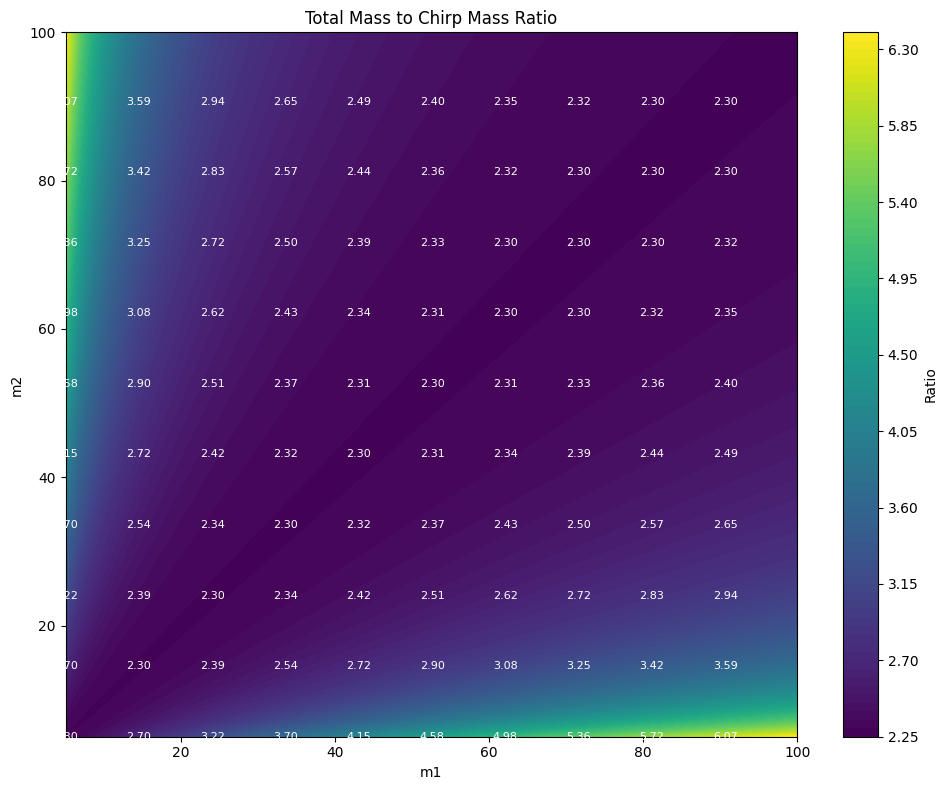

In [169]:
# Create a meshgrid
M1, M2 = np.meshgrid(m1, m2)

# Calculate the scalar ratio
scalar = sum_mass / chirp_mass

# Create the figure and axes
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Plot the scalar ratio
contour1 = ax.contourf(M1, M2, scalar, levels=100, cmap="viridis")
fig.colorbar(contour1, ax=ax, label="Ratio")
ax.set_xlabel("m1")
ax.set_ylabel("m2")
ax.set_title("Total Mass to Chirp Mass Ratio")

# Add text annotations for scalar ratio
for i in range(0, M1.shape[0], 50):
    for j in range(0, M2.shape[1], 50):
        ax.text(
            M1[i, j],
            M2[i, j],
            f"{scalar[i, j]:.2f}",
            color="white",
            fontsize=8,
            ha="center",
            va="center",
        )

# Show the plot
plt.tight_layout()
plt.show()

# recalibrate on O4

In [12]:
import pandas as pd
import numpy as np
import astropy.cosmology as cos
from astropy.cosmology import Planck15 as cosmo
import matplotlib.pyplot as plt

In [36]:
data = {
    "GraceDBId": ["S250326y", "S250118t", "S250204ax"],
    "Mass_real": [64, 140, 42],
    "Mass_predicted": [190, 222, 76],
    "FAR (Hz)": [5400, 79.7, 100],
    "dl (Mpc)": [5410, 6630, 2060],
}
df = pd.DataFrame(data)

# parameter modifications
df["LOG10FAR"] = np.log10(df["FAR (Hz)"])
df["z"] = cos.z_at_value(
    cosmo.luminosity_distance, df["dl (Mpc)"].values * u.Mpc, method="bounded"
).value
df["LOG10(z+1)"] = np.log10(df["z"] + 1)
df["LOG10dl/dl_bns"] = np.log10(df["dl (Mpc)"].values / 168.0)

df

,GraceDBId,Mass_real,Mass_predicted,FAR (Hz),dl (Mpc),LOG10FAR,z,LOG10(z+1),LOG10dl/dl_bns
0,S250326y,64,190,5400.0,5410,3.732394,0.831232,0.262743,1.507888
1,S250118t,140,222,79.7,6630,1.901458,0.980627,0.296803,1.596204
2,S250204ax,42,76,100.0,2060,2.000000,0.372627,0.137553,1.088558


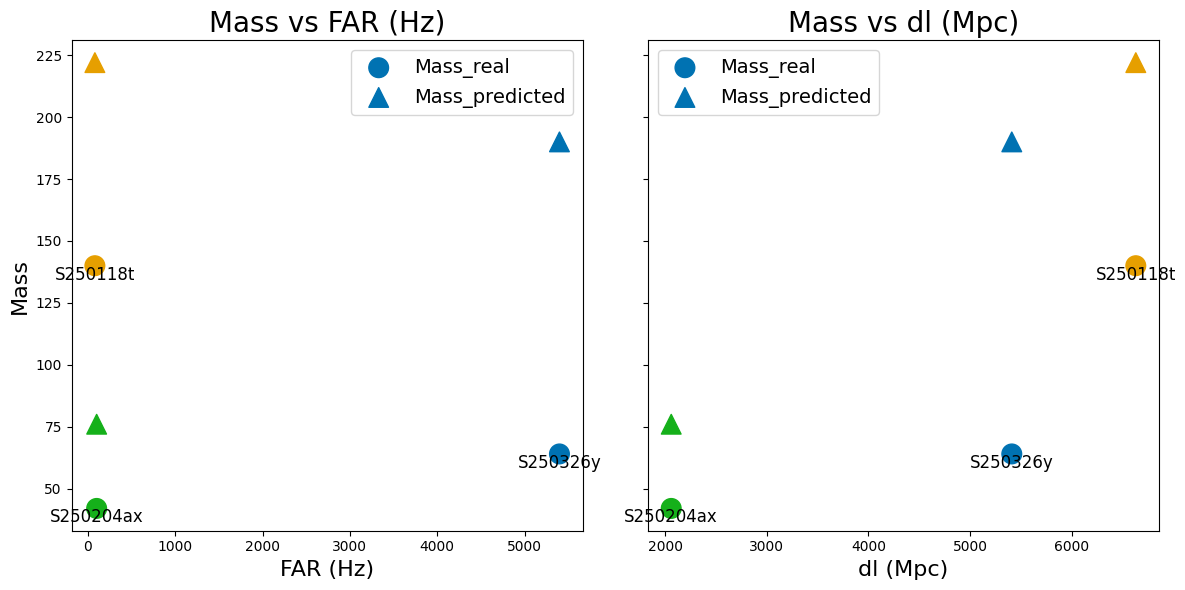

In [34]:
# Create a figure with 3 subplots arranged side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
colors = ["#0072B2", "#E69F00", "#15b01a"]

# 1. Mass_real and Mass_predicted vs FAR
axes[0].scatter(
    df["FAR (Hz)"], df["Mass_real"], marker="o", s=200, color=colors, label="Mass_real"
)
axes[0].scatter(
    df["FAR (Hz)"],
    df["Mass_predicted"],
    marker="^",
    s=200,
    color=colors,
    label="Mass_predicted",
)
axes[0].set_title("Mass vs FAR (Hz)", fontsize=20)
axes[0].set_xlabel("FAR (Hz)", fontsize=16)
axes[0].set_ylabel("Mass", fontsize=16)
axes[0].legend(fontsize=14)
for i, txt in enumerate(df["GraceDBId"]):
    axes[0].text(
        df["FAR (Hz)"].iloc[i],
        df["Mass_real"].iloc[i],
        str(txt),
        fontsize=12,
        ha="center",
        va="top",
    )

# 2. Mass_real and Mass_predicted vs dl
axes[1].scatter(
    df["dl (Mpc)"], df["Mass_real"], marker="o", s=200, color=colors, label="Mass_real"
)
axes[1].scatter(
    df["dl (Mpc)"],
    df["Mass_predicted"],
    marker="^",
    s=200,
    color=colors,
    label="Mass_predicted",
)
axes[1].set_title("Mass vs dl (Mpc)", fontsize=20)
axes[1].set_xlabel("dl (Mpc)", fontsize=16)
axes[1].legend(fontsize=14)
for i, txt in enumerate(df["GraceDBId"]):
    axes[1].text(
        df["dl (Mpc)"].iloc[i],
        df["Mass_real"].iloc[i],
        str(txt),
        fontsize=12,
        ha="center",
        va="top",
    )

# # 3. Mass_real and Mass_predicted vs LOG10(z+1)
# axes[2].scatter(df['z'], df['Mass_real'], marker='o', s=200, color=colors, label='Mass_real')
# axes[2].scatter(df['z'], df['Mass_predicted'], marker='^', s=200, color=colors, label='Mass_predicted')
# axes[2].set_title('Mass vs z',fontsize=20)
# axes[2].set_xlabel('z',fontsize=16)
# axes[2].legend(fontsize=14)
# for i, txt in enumerate(df['GraceDBId']):
#     axes[2].text(df['z'].iloc[i], df['Mass_real'].iloc[i], str(txt), fontsize=12, ha='center', va='top')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

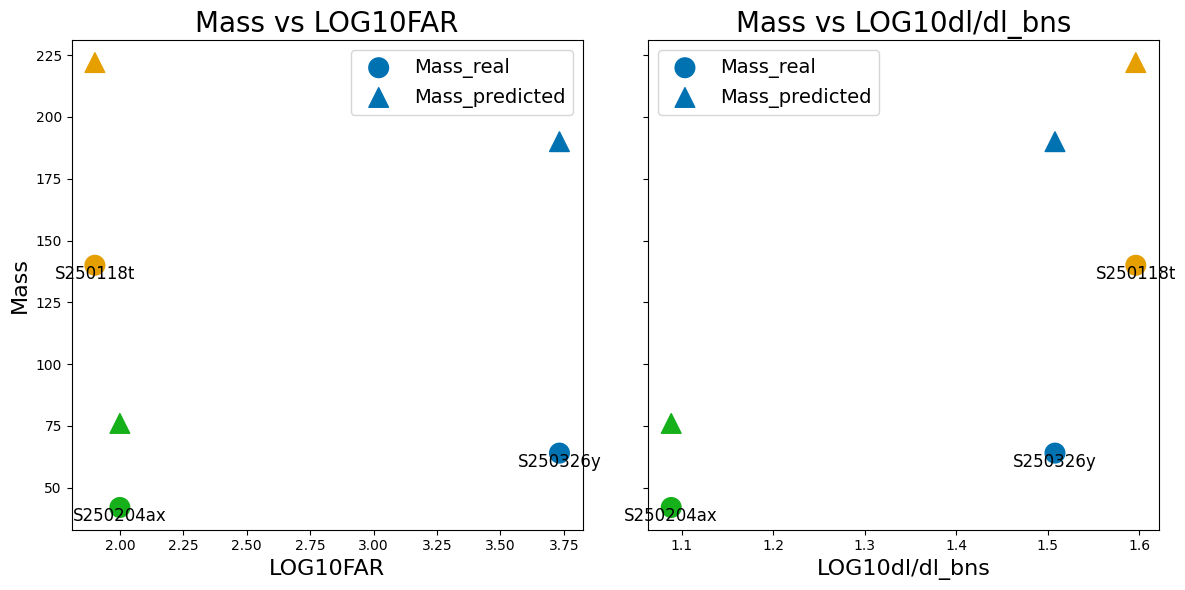

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
colors = ["#0072B2", "#E69F00", "#15b01a"]

# 1. Mass_real and Mass_predicted vs LOG10FAR
axes[0].scatter(
    df["LOG10FAR"], df["Mass_real"], marker="o", s=200, color=colors, label="Mass_real"
)
axes[0].scatter(
    df["LOG10FAR"],
    df["Mass_predicted"],
    marker="^",
    s=200,
    color=colors,
    label="Mass_predicted",
)
axes[0].set_title("Mass vs LOG10FAR", fontsize=20)
axes[0].set_xlabel("LOG10FAR", fontsize=16)
axes[0].set_ylabel("Mass", fontsize=16)
axes[0].legend(fontsize=14)
for i, txt in enumerate(df["GraceDBId"]):
    axes[0].text(
        df["LOG10FAR"].iloc[i],
        df["Mass_real"].iloc[i],
        str(txt),
        fontsize=12,
        ha="center",
        va="top",
    )

# 2. Mass_real and Mass_predicted vs LOG10dl/dl_bns
axes[1].scatter(
    df["LOG10dl/dl_bns"],
    df["Mass_real"],
    marker="o",
    s=200,
    color=colors,
    label="Mass_real",
)
axes[1].scatter(
    df["LOG10dl/dl_bns"],
    df["Mass_predicted"],
    marker="^",
    s=200,
    color=colors,
    label="Mass_predicted",
)
axes[1].set_title("Mass vs LOG10dl/dl_bns", fontsize=20)
axes[1].set_xlabel("LOG10dl/dl_bns", fontsize=16)
axes[1].legend(fontsize=14)
for i, txt in enumerate(df["GraceDBId"]):
    axes[1].text(
        df["LOG10dl/dl_bns"].iloc[i],
        df["Mass_real"].iloc[i],
        str(txt),
        fontsize=12,
        ha="center",
        va="top",
    )

plt.tight_layout()
plt.show()

In [ ]:
# train and save model
import astropy.cosmology as cos
from astropy.cosmology import Planck15 as cosmo
from sklearn.neural_network import MLPRegressor
import pickle


def save_mass_mlp(filename, dl_bns):
    """
    Train and save the MLP model
    """
    df = pd.read_csv(
        "../../../data/bbh/ligoO3/ligo_o3.dat", sep=r"\s+", header=0
    )  # delim_whitespace = True
    df["z"] = cos.z_at_value(
        cosmo.luminosity_distance, df["dl"].values * u.Mpc, method="bounded"
    ).value
    d = df[["mass", "masserr", "dl", "z", "a90", "far"]].to_numpy().T
    d[1] = d[1] / (d[0] * np.log(10))  # error/mass ?? unsure why this is done
    d[0] = np.log10(d[0])  # log mass
    d[2] = np.log10(d[2] / dl_bns)  # log dl / dl_bns
    d[3] = np.log10(1 + d[3])  # log (1 + z)
    d[4] = np.log10(d[4])  # log a_90
    d[5] = np.log10(d[5])  # log far in yr

    # Define data and target
    X = np.array([d[2], d[3], d[5]]).T  # training on distance(Mpc), redshift+1, FAR
    y = d[0]
    # Train model
    model = MLPRegressor(random_state=1, max_iter=10000)
    model.fit(X, y)
    # Save the trained model
    pickle.dump(model, open(filename, "wb"))


# save_mass_mlp('../../../data/bbh/ligoO3/mlp_model_dlbns168.sav', dl_bns = 168.)